Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [1]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
#interactive plotting in separate window
%matplotlib qt 
#%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 12})

import numpy as np
import sympy
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
from utils import save_data, load_data
import time

## Folder dir for saving and loading files

In [2]:
#model_name = 'mtm_2spring_tendon'
model_name = 'mtm'

model_folder = 'data/' + model_name + '/model/'

---
# 2 - Robot modelling

## Robot geometry definition in following order

| Joint number | prev link | succ links | $a$ | $\alpha$ | $d$ | $\theta$ | link inertia | motor inertia | friction |
|--------------|-----------|------------|-----|----------|-----|----------|--------------|---------------|---------|

In [3]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = new_sym('q:11')
_pi = sympy.pi

dh = []
springs = []
friction_type = []


# old model

# define paralelogram coordinate relation
# q3 = -q2 + q8
# q9 = -q8 + q2
# q10 = q8 - q2

# dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
#       (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, True),
#       (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
#       (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
#       (4,   3,  [5],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
#       (5,   4,  [6],    0,     _pi/2,  0,        q5,       True,  False, True),
#       (6,   5,  [7],    0,     -_pi/2, 0,        q6+_pi/2, True,  False, True),
#       (7,   6,  [],     0,     -_pi/2, 0,        q7+_pi,   True,  False, True),
#       (8,   1,  [9],    0,     -_pi/2, 0,        q8+_pi,   True,  False, True),
#       (9,   8,  [10],   0.1,   0,      0,        q9-_pi/2, True,  False, True),
#       (10,  9,  [],     0.279, 0,      0,        q10,      False, False, True)]

# q = q5
# r_s = 0.0075
# h_s = 0.1035
# l_r = 0.0613
# q_o = 23.0/180.0*_pi
# l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
# d_l = l - l_r
# r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
# tau_s = r_f * d_l # * 27.86
# springs = [tau_s, -q4]

# friction_type = ['Coulomb', 'viscous', 'offset']
# tendon_couplings = [(4, 3, 2.0/3.0)] # tau_3 += 2/3*tau_4
# print(model_name)


# new model
# define paralelogram coordinate relation
qd2 = q2
qd3 = -q2 + q3
qd4 = 0.6697*q2 - 0.6697*q3 + q4


qmd1 = q1
qmd2 = qd2
qmd30 = qd3
qmd31 = qd3 + qd2 
qmd32 = -qd3
qmd33 = q3
qmd4 = qd4
qmd5 = q5
qmd6 = q6
qmd7 = q7

# q31 = q3 + q2 
# q32 = -q3

l_base2pitch = 215.4 * 0.001
l_arm = 279.4 * 0.001
l_back2front = 100 * 0.001
l_forearm = 364.5 * 0.001
h =105.6 * 0.001

L_b = 0
L_1 = 1
L_2 = 2
L_30 = 3
L_31 = 4
L_32 = 5
L_4 = 6
L_5 = 7
L_6 = 8
L_7 = 9


dh = [(L_b,  -1,   [L_1],       0,            0,      0,             0,         False, False, False),
      (L_1,  L_b,  [L_2, L_30], 0,            0,      -l_base2pitch, qmd1,        True,  False, True),
      (L_2,  L_1,  [L_30],      0,            -_pi/2, 0,             qmd2+_pi/2,  True,  False, True),
      (L_30, L_2,  [L_4],       l_arm,        0,      0,             qmd30+_pi/2,  True,  False, True),
      (L_31, L_1,  [L_32],      0,            -_pi/2, 0,             qmd31+_pi,   True,  False, True),
      (L_32, L_31, [],          l_back2front, 0,      0,             qmd32-_pi/2, True,  False, True),
      (L_4,  L_30, [L_5],       l_forearm,    -_pi/2, 0.151,         qmd4,        True,  False, True),
      (L_5,  L_4,  [L_6],       0,            _pi/2,  0,             qmd5,        True,  False, True),
      (L_6,  L_5,  [L_7],       0,            -_pi/2, 0,             qmd6+_pi/2,  True,  False, True),
      (L_7,  L_6,  [],          0,            -_pi/2, 0,             qmd7+_pi,    True,  False, True)]

q = qmd5
r_s = 0.0075
h_s = 0.1035
l_r = 0.0613
q_o = 23.0/180.0*_pi
l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
d_l = l - l_r
r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
tau_s = r_f * d_l # * 27.86
springs = [tau_s, -qmd4]

friction_type = ['Coulomb', 'viscous', 'offset']
print(model_name)


print(friction_type)
robot_def = RobotDef(dh,
                     springs=springs,
                     dh_convention='mdh',
                     friction_type=friction_type)

mtm
['Coulomb', 'viscous', 'offset']


In [50]:
robot_def.dq_for_frame

In [51]:
robot_def.coordinates_joint_type

['R', 'R', 'R', 'R', 'R', 'R', 'R']

In [52]:
robot_def.bary_params

## Create kinematics chain

In [53]:
%time geom = Geometry(robot_def)

Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
CPU times: user 55min 33s, sys: 9.01 s, total: 55min 42s
Wall time: 55min 33s


In [54]:
angle = [0, 0, 0, 0, 0, 0, 0]
geom.draw_geom(angle)

## Create dynamics

In [55]:
%time dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating the link kinetic energy of 1/9
Calculating the link kinetic energy of 2/9
Calculating the link kinetic energy of 3/9
Calculating the link kinetic energy of 4/9
Calculating the link kinetic energy of 5/9
Calculating the link kinetic energy of 6/9
Calculating the link kinetic energy of 7/9
Calculating the link kinetic energy of 8/9
Calculating the link kinetic energy of 9/9
Calculating joint torques...
tau of q1
tau of q2
tau of q3
tau of q4
tau of q5
tau of q6
tau of q7
Adding frictions and springs...
Add motor inertia...
Calculating gregressor...
Calculating M, C and G...
Calculating base parameter...
base parameter number: 71
Creating H_b function...
Finished creating robot dynamics
CPU times: user 28min 11s, sys: 9.21 s, total: 28min 20s
Wall time: 28min 10s


In [56]:
robot_def.bary_params

In [57]:
sympy.Matrix(dyn.base_param)

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [58]:
from data import RobotModel

# Data to be saved
robot_model = RobotModel(dyn)

# Save
save_data(model_folder, model_name, robot_model)
print('Saved {} parameters'.format(len(robot_model.base_param)))

Saved 71 parameters


---
# 3 - Excitation trajectory optimization

In [138]:
model_name = 'mtm'

Load Data

In [139]:
from utils import load_data
model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder, model_name)

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [152]:
#trajectory_name = 'one'
#trajectory_name = 'two'
trajectory_name = 'three'

In [153]:
from numpy import deg2rad

optimal_trajectory_folder = 'data/optimal_trajectory/'
trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'

base_freq = 0.1
fourier_order = 6

cartesian_constraints = []


joint_constraints = [(qmd1,  deg2rad(-57), deg2rad(29), deg2rad(-160), deg2rad(160)),
                     (qmd2,  deg2rad(-10), deg2rad(60), deg2rad(-180), deg2rad(180)),
                     (qmd30, deg2rad(-30), deg2rad(30), deg2rad(-180), deg2rad(180)),
                     (qmd4,  deg2rad(-40), deg2rad(195), deg2rad(-360), deg2rad(360)),
                     (qmd5,  deg2rad(-87), deg2rad(180), deg2rad(-360), deg2rad(360)),
                     (qmd6,  deg2rad(-40), deg2rad(38), deg2rad(-360), deg2rad(360)),
                     (qmd7,  deg2rad(-460), deg2rad(450), deg2rad(-720), deg2rad(720)),
                     (qmd31, deg2rad(-9), deg2rad(39), deg2rad(-360), deg2rad(360))]

    
traj_optimizer = TrajOptimizer(robot_model, fourier_order, base_freq,
                               joint_constraints=joint_constraints,
                               cartesian_constraints = cartesian_constraints)
                                                                                                 
                                                                                                                     
traj_optimizer.optimize()


joint constraint number: 8
cartesian constraint number: 0
constraint number: 32
frames_constrained: []
Condition number: 182.418055728
Condition number: 182.418054685
Condition number: 79.6974341968
Condition number: 87.419929406
Condition number: 132.620808026
Condition number: 351.635355009
Condition number: 272.22746721
Condition number: 263.667003407
Condition number: 258.757371183
Condition number: 254.283940493
Condition number: 251.910413663
Condition number: 250.423027512
Condition number: 249.062375296
Condition number: 248.804152031
Condition number: 247.378784806
Condition number: 246.833105395
Condition number: 244.952188398
Condition number: 244.841524701
Condition number: 244.495286742
Condition number: 243.823564004
Condition number: 243.442721583
Condition number: 242.972930948
Condition number: 241.570462105
Condition number: 241.068598763
Condition number: 240.851334731
Condition number: 240.588676535
Condition number: 240.389364166
Condition number: 240.140171442
Con

In [158]:
robot_model.coordinates

In [159]:
reg_norm_mat = traj_optimizer.calc_normalize_mat()

## Plot optimal excitation trajectory

In [160]:
traj_optimizer.calc_frame_traj()

In [157]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj,traj_optimizer.frame_traj,
                           traj_optimizer.const_frame_ind, robot_model.coordinates)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

# traj_plotter.plot_frame_traj(True)

## Save trajectory for later use

In [161]:
dof_order_bf_x_norm = (traj_optimizer.fourier_traj.dof, fourier_order,
                       base_freq, traj_optimizer.x_result, reg_norm_mat)
save_data(trajectory_folder, trajectory_name, dof_order_bf_x_norm)

In [162]:
from IPython.display import HTML, display
import tabulate

table = []
table.append(["joint", 'qo'] +
             ["a"+str(i+1) for i in range(fourier_order)] +
             ["b"+str(i+1) for i in range(fourier_order)])
for i in range(traj_optimizer.fourier_traj.dof):
    line = []
    line.append(robot_model.coordinates[i])
    line += np.round(traj_optimizer.x_result[i*(1 + fourier_order*2): (i+1)*(1 + fourier_order*2)], 4).tolist()
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

joint,qo,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
q1,-0.2419,-0.0,-0.0,0.0,-0.0,-0.0,2.0443,-0.0,-0.0,-0.0,-0.0,0.0,2.0443
q2,0.2161,0.0122,-0.1319,-0.2992,0.4359,-0.437,0.3491,0.0504,-0.1885,0.2935,0.2332,0.8563,-0.2548
q3,0.243,-0.03,-0.0195,-0.1391,0.203,0.0765,0.9544,0.0733,-0.0745,0.0192,0.3376,-0.2771,-0.4492
q4,0.3709,-0.2769,0.3799,-1.2057,-0.619,0.6598,-1.6104,0.4056,-0.5974,-0.7845,0.4465,-2.2446,1.396
q5,0.8397,-0.401,-0.8114,1.8731,1.3061,0.0171,0.5626,-0.3606,0.6975,-2.3145,-0.0577,-0.2198,-1.4031
q6,-0.1884,0.0233,-0.1396,0.2178,0.3955,-0.1119,0.2195,-0.1626,-0.0626,-0.1383,0.2679,0.1551,0.0442
q7,0.5872,1.7872,0.1122,2.1347,0.7793,-3.2533,0.5235,3.4956,1.5102,3.9404,-1.8533,-1.8979,1.9001


---
# Data processing

In [4]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

## Load data

### Load robot model

In [5]:
# Names as Arguments
model_name = 'mtm'
#model_name = 'mtm_2spring_tendon'
training_trajectory_name = 'one'


model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder,model_name)


trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
dof, fourier_order, base_freq, traj_optimizer_result, reg_norm_mat = load_data(trajectory_folder,
                                                                               training_trajectory_name)
print("dof: {}".format(dof))
print("Fourier order: {}".format(fourier_order))
print("Base frequency: {}".format(base_freq))

dof: 7
Fourier order: 6
Base frequency: 0.1


### Load traning data set

In [6]:
# training_trajectory_name = 'one'

results_folder = 'data/' + model_name +'/measured_trajectory/'
training_results_data_file = results_folder + training_trajectory_name + '_results.csv'

trajectory_sampling_rate = 500
t_train, q_raw_train, dq_raw_train, tau_raw_train = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)

(<type 'numpy.ndarray'>, (14999, 21))


### Training trajectory

In [7]:
from trajectory_optimization import FourierTraj
fourier_traj_train = FourierTraj(dof, fourier_order, base_freq, sample_num_per_period=20)
traj_plotter_train = TrajPlotter(fourier_traj_train, coordinates=robot_model.coordinates)
traj_plotter_train.plot_desired_traj(traj_optimizer_result)

### Load test data set

In [8]:
test_trajectory_name = 'two'

results_folder = 'data/' + model_name +'/measured_trajectory/'
test_results_data_file = results_folder + test_trajectory_name + '_results.csv'

trajectory_sampling_rate = 500
t_test, q_raw_test, dq_raw_test, tau_raw_test = load_trajectory_data(test_results_data_file,
                                                                trajectory_sampling_rate)

(<type 'numpy.ndarray'>, (14999, 21))


## Calculate filter cut-off frequency

In [9]:
# times of the highest frequency in the Fourier series

fc_mult = [4]
#fc_mult = [5, 5, 5, 3, 4, 4, 4]

#fc_mult = 4
fc = np.array(fc_mult)*base_freq* fourier_order 

print("Cut frequency: {}".format(fc))

Cut frequency: [2.4]


## Differentiation and filtering

### Traning data

In [10]:
t_cut_train, q_f_train, dq_f_train, ddq_f_train, tau_f_train, q_raw_cut_train, tau_raw_cut_train =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_train, q_raw_train, dq_raw_train, tau_raw_train, fc, fc, fc, fc)
plot_trajectory_data(t_cut_train, q_raw_cut_train, q_f_train, dq_f_train, ddq_f_train,
                     tau_raw_cut_train, tau_f_train)

[0.030159289474462017, 0.030159289474462017, 0.030159289474462017, 0.030159289474462017, 0.030159289474462017, 0.030159289474462017, 0.030159289474462017]
q_raw shape: (14999, 7)
plot shape: 470


### Test data

In [11]:
t_cut_test, q_f_test, dq_f_test, ddq_f_test,tau_f_test, q_raw_cut_test, tau_raw_cut_test =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_test, q_raw_test, dq_raw_test, tau_raw_test, fc, fc, fc, fc)
plot_trajectory_data(t_cut_test, q_raw_cut_test, q_f_test, dq_f_test, ddq_f_test,
                     tau_raw_cut_test, tau_f_test)

[0.030159289474462017, 0.030159289474462017, 0.030159289474462017, 0.030159289474462017, 0.030159289474462017, 0.030159289474462017, 0.030159289474462017]
q_raw shape: (14999, 7)
plot shape: 470


---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [12]:
base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b_train, tau_s_train = gen_regressor(base_param_num, H_b_func, q_f_train,
                                       dq_f_train, ddq_f_train, tau_f_train)

In [13]:
W_b_train.shape, tau_s_train.shape
#print np.linalg.cond(W_b_train)

In [14]:
xb_ols = np.linalg.lstsq(W_b_train, tau_s_train)[0]

/home/yan/anaconda2/envs/dynamics/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [15]:
#sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_ols))

from IPython.display import HTML, display
import tabulate

table = [["Base Parameter", "Value"]]

for i in range(robot_model.base_num):
    param_str = str(sympy.Matrix(robot_model.base_param)[i])
    max_disp_len = 50
    line = [param_str if len(param_str) <= max_disp_len 
            else param_str[:max_disp_len] + '...', xb_ols[i]]
    #['%.7s ...'%b if len(str(b)) > 7 else str(b)
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

Base Parameter,Value
1.0*L9xy,5.758182284655661e-06
1.0*L9xz,1.3425852142395778e-06
1.0*L9yz,-3.326148524998877e-05
1.0*L8xy,0.00010349472987746433
1.0*L8yz,0.000165205676604668
1.0*L8xz,0.00022242519012269477
1.0*L7xy,-8.826564870790653e-05
1.0*L8zz + 1.0*L9yy,0.0008029287327820291
1.0*L9zz,9.60102282947465e-05
1.0*L7yz,0.0003597184108942782


## Compare measured torque and predicted torque on the training set

### Generate predicted torque

In [16]:
tau_p_train = np.zeros(tau_f_train.shape)
tau_ps_train = W_b_train.dot(xb_ols)
for i in range(dof):
    tau_p_train[:, i] = tau_ps_train[i::dof]
    

### Evaluate regression

In [17]:
var_regression_error_ols = np.linalg.norm(tau_ps_train - tau_s_train) / \
                        (tau_ps_train.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols *
                                 np.linalg.inv(W_b_train.transpose().dot(W_b_train))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.00010238508357496275
standard deviation of xb using OLS:
[1.54076723e-06 1.19477900e-06 1.18175285e-06 1.01676398e-05
 7.97110930e-06 8.52705814e-06 1.00306087e-05 1.09879732e-05
 2.34277382e-06 1.04507212e-05 1.15993350e-05 3.90209186e-06
 3.99171094e-06 1.07656788e-05 3.07180219e-05 1.63573306e-05
 1.20446931e-05 4.33608443e-05 2.75432921e-05 3.22061511e-05
 2.31915751e-05 1.59750012e-05 2.67647909e-05 3.03023909e-05
 2.16730058e-05 4.23740874e-04 1.05632142e-04 3.85893729e-04
 1.40097251e-03 2.59096224e-05 2.09621594e-05 1.75090860e-04
 1.08400571e-04 1.71268732e-04 2.04948111e-04 9.39706141e-05
 4.11319323e-05 6.73300156e-05 5.90815783e-05 2.31725136e-04
 6.25490583e-05 1.67861226e-04 2.14891151e-04 4.67382996e-04
 5.12436947e-04 3.34087942e-04 2.53227032e-05 8.53854889e-05
 6.46589460e-05 1.64520105e-04 6.15678323e-04 3.79941884e-04
 2.65273851e-03 2.87349777e-04 3.36913151e-04 8.41166938e-05
 1.03098252e-04 1.20660300e-04 9.10156795e-05 8

### Plot measured torque and predicted torque

In [18]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on the test set

In [19]:
W_b_test, tau_s_test = gen_regressor(base_param_num, H_b_func, q_f_test,
                                       dq_f_test, ddq_f_test, tau_f_test)

tau_p_test = np.zeros(tau_f_test.shape)
tau_ps_test = W_b_test.dot(xb_ols)
for i in range(dof):
    tau_p_test[:, i] = tau_ps_test[i::dof]

In [20]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

## Weighted Least Square (WLS)

### Training data set

In [21]:
# weight = np.sqrt(np.linalg.norm(tau_f - tau_p, axis=0)/(tau_f.shape[0] - base_param_num))
weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)

In [22]:
W_b_train.shape, tau_s_train.shape

In [23]:
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_train.shape[0]/weight.shape[0])

In [24]:
weights.shape

In [25]:
W_b_wls_train = np.multiply(W_b_train, np.asmatrix(weights).transpose())
tau_s_wls_train = np.multiply(tau_s_train, weights)

In [26]:
xb_wls = np.linalg.lstsq(W_b_wls_train, tau_s_wls_train)[0]

/home/yan/anaconda2/envs/dynamics/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [27]:
#np.set_printoptions(precision=2)
sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_wls))

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [28]:
tau_p_wls_train = np.zeros(tau_f_train.shape)
tau_ps_wls_train = W_b_train.dot(xb_wls)
for i in range(dof):
    tau_p_wls_train[:, i] = tau_ps_wls_train[i::dof]

In [29]:
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_wls_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type, 
                   robot_model.coordinates)

In [30]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_wls_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.07716752, 0.20718089, 0.10344898, 0.3035566 , 0.21788342,
       0.2662413 , 0.28237656])

In [31]:
robot_model.bary_param

### Test data set

In [32]:
weight = np.max(tau_f_test, axis=0) - np.min(tau_f_test, axis=0)
weight
weight[1] /= 1
weight[2] /= 1
weight[3] /= 1
weight
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_test.shape[0]/weight.shape[0])

W_b_wls_test = np.multiply(W_b_test, np.asmatrix(weights).transpose())
tau_s_wls_test = np.multiply(tau_s_test, weights)

tau_p_wls_test = np.zeros(tau_f_test.shape)
tau_ps_wls_test = W_b_test.dot(xb_wls)
for i in range(dof):
    tau_p_wls_test[:, i] = tau_ps_wls_test[i::dof]

plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_wls_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

In [33]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_wls_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.09168226, 0.30576121, 0.13519596, 0.49678783, 0.42539932,
       0.31499447, 0.35645224])

## Convex optimization

### Generate regressor matrix for barycentric parameters

In [66]:
from identification import SDPOpt

bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_train, tau_s_train = gen_regressor(bary_param_num, H_func,
                                     q_f_train, dq_f_train, ddq_f_train, tau_f_train)

In [67]:
W_w_train = np.multiply(W_train, np.asmatrix(weights).transpose())
tau_w_s_train = np.multiply(tau_s_train, weights)

In [68]:
len(robot_model.std_param)

| min mass | max mass | min $r_x$ | max $r_x$ | min $r_y$ | max $r_y$ | min $r_z$ | max $r_z$ | max $F_c$ | max $F_v$ | max $F_o$ |
|----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|--------------|-----------|

In [69]:
sdp_constraints = []
spring_constraints = []
if model_name == 'mtm' or model_name == 'mtm_2spring_tendon':
    sdp_constraints = [(2, 20, -0.1, 0.1, -0.1, 0.1, -0.1, 0.3, 0.2, 0.2, 0.2),
                      (1, 10, -0.1, 0.2, -0.05, 0.05, -0.05, 0.05, 0.2, 0.2, 0.2),
                      (1, 10, -0.0, 0.3, -0.02, 0.02, -0.01, 0.01, 0.2, 0.2, 0.2),
                      (0.2, 5, -0.01, 0.01, -0.0, 0.1, -0.1, 0.0, 0.2, 0.2, 0.1),
                      (0.1, 2, -0.01, 0.01, -0.05, 0.0, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.05, 0.5, -0.005, 0.005, -0.00, 0.05, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.05, 0.5, -0.000, 0.000, -0.00, 0.00, -0.00, 0.05, 0.1, 0.1, 0.1),
                      (1, 10, -0.10, 0.05, -0.05, 0.05, -0.05, 0.05, 0.1, 0.2, 0.2),
                      (0.05, 0.5, 0.10, 0.15, -0.00, 0.00, 0.025, 0.03, 0.1, 0.1, 0.1),
                      (0.0, 0, 0.00, 0.00, -0.00, 0.00, 0.000, 0.00, 0.1, 0.1, 0.0)]
    spring_constraints = [(250, 300), (0.001, 0.1)]
elif model_name == 'mtm_3links':
    sdp_constraints = [(0.5, 10, -0.1, 0.1, -0.1, 0.1, -0.1, 0.3, 0.5, 0.5, 0.5),
                      (0.3, 5, -0.1, 0.2, -0.05, 0.05, -0.05, 0.05, 0.5, 0.5, 0.5),
                      (0.1, 3, -0.0, 0.3, -0.02, 0.02, -0.01, 0.01, 0.1, 0.5, 0.5),
                      (0.1, 1, -0.01, 0.01, -0.0, 0.1, -0.1, 0.0, 0.1, 0.1, 0.1),
                      (0.02, 0.3, -0.01, 0.01, -0.05, 0.0, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.02, 0.2, -0.005, 0.005, -0.00, 0.05, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.01, 0.1, -0.000, 0.000, -0.00, 0.00, -0.00, 0.05, 0.1, 0.1, 0.1),
                      (0.3, 5, -0.10, 0.05, -0.05, 0.05, -0.05, 0.05, 0.5, 0.5, 0.5),
                      (0.3, 5, 0.10, 0.15, -0.00, 0.00, 0.025, 0.03, 0.1, 0.1, 0.1),
                      (0.3, 5, 0.10, 0.15, -0.00, 0.00, 0.025, 0.03, 0.1, 0.1, 0.1)]
else:
    raise Exception("No robot name matches " + model_name)

In [70]:


sdp_opt_std = SDPOpt(W_w_train, tau_w_s_train, robot_model,
                     sdp_constraints, spring_constraints)
# sdp_opt_std = SDPOpt(W, tau_s, robot_model, sdp_constraints)
%time sdp_opt_std.solve()

Regressor shape: (102123, 122)
Regressand shape: (102123,)
Creating variables...
Creating optimization objective...
Creating constraints...
Solving problem...
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 4727149, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 50000, normalize = 1, scale = 1.00
Variables n = 123, constraints m = 102451
Cones:	linear vars: 137
	soc vars: 102125, soc blks: 1
	sd vars: 189, sd blks: 9
Setup time: 2.07e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.39e+01  9.74e-01  1.00e+00 -1.02e+04 -2.26e-03  5.06e-12  2.12

  9400| 8.11e-02  2.56e-05  2.82e-04  4.45e-01  4.45e-01  2.11e-12  7.69e+02 
  9500| 8.11e-02  1.20e-05  2.86e-04  4.49e-01  4.50e-01  4.21e-13  7.74e+02 
  9600| 8.11e-02  4.14e-05  2.89e-04  4.54e-01  4.55e-01  2.11e-12  7.80e+02 
  9700| 8.11e-02  6.02e-05  2.95e-04  4.59e-01  4.59e-01  2.11e-12  7.85e+02 
  9800| 8.10e-02  7.32e-05  3.01e-04  4.63e-01  4.64e-01  4.21e-13  7.90e+02 
  9900| 8.10e-02  7.41e-05  3.06e-04  4.68e-01  4.69e-01  4.21e-13  7.96e+02 
 10000| 8.11e-02  6.43e-05  3.09e-04  4.73e-01  4.73e-01  1.26e-12  8.01e+02 
 10100| 8.11e-02  4.79e-05  3.13e-04  4.77e-01  4.78e-01  2.95e-12  8.06e+02 
 10200| 8.11e-02  2.24e-05  3.18e-04  4.82e-01  4.83e-01  2.11e-12  8.11e+02 
 10300| 8.11e-02  1.49e-05  3.23e-04  4.87e-01  4.88e-01  4.21e-13  8.17e+02 
 10400| 8.11e-02  3.03e-05  3.28e-04  4.92e-01  4.92e-01  1.26e-12  8.22e+02 
 10500| 8.11e-02  4.94e-05  3.31e-04  4.96e-01  4.97e-01  2.95e-12  8.27e+02 
 10600| 8.10e-02  6.10e-05  3.35e-04  5.01e-01  5.02e-01  1.26e-

 20000| 8.10e-02  3.00e-06  6.10e-04  9.43e-01  9.45e-01  4.21e-13  1.32e+03 
 20100| 8.10e-02  7.14e-06  6.12e-04  9.48e-01  9.49e-01  4.21e-13  1.32e+03 
 20200| 8.10e-02  5.26e-06  6.14e-04  9.52e-01  9.54e-01  2.95e-12  1.33e+03 
 20300| 8.10e-02  8.82e-06  6.16e-04  9.57e-01  9.59e-01  4.21e-13  1.33e+03 
 20400| 8.10e-02  9.51e-06  6.18e-04  9.62e-01  9.64e-01  4.21e-13  1.34e+03 
 20500| 8.10e-02  8.59e-06  6.20e-04  9.66e-01  9.68e-01  4.21e-13  1.34e+03 
 20600| 8.10e-02  9.54e-06  6.22e-04  9.71e-01  9.73e-01  4.21e-13  1.35e+03 
 20700| 8.10e-02  5.09e-06  6.24e-04  9.76e-01  9.78e-01  4.21e-13  1.35e+03 
 20800| 8.10e-02  6.79e-06  6.26e-04  9.81e-01  9.82e-01  4.21e-13  1.36e+03 
 20900| 8.10e-02  3.99e-06  6.28e-04  9.85e-01  9.87e-01  1.26e-12  1.36e+03 
 21000| 8.10e-02  5.73e-06  6.29e-04  9.90e-01  9.92e-01  2.95e-12  1.37e+03 
 21100| 8.10e-02  7.98e-06  6.31e-04  9.95e-01  9.97e-01  1.26e-12  1.37e+03 
 21200| 8.10e-02  6.89e-06  6.33e-04  9.99e-01  1.00e+00  1.26e-

 30600| 8.09e-02  4.20e-06  7.56e-04  1.44e+00  1.44e+00  1.27e-12  1.85e+03 
 30700| 8.09e-02  2.63e-06  7.57e-04  1.45e+00  1.45e+00  2.11e-12  1.85e+03 
 30800| 8.09e-02  3.41e-06  7.58e-04  1.45e+00  1.45e+00  1.27e-12  1.86e+03 
 30900| 8.09e-02  3.81e-06  7.59e-04  1.45e+00  1.46e+00  4.22e-13  1.86e+03 
 31000| 8.09e-02  2.39e-06  7.59e-04  1.46e+00  1.46e+00  1.27e-12  1.87e+03 
 31100| 8.09e-02  4.30e-06  7.60e-04  1.46e+00  1.47e+00  1.27e-12  1.87e+03 
 31200| 8.09e-02  2.18e-06  7.61e-04  1.47e+00  1.47e+00  1.27e-12  1.87e+03 
 31300| 8.09e-02  3.89e-06  7.62e-04  1.47e+00  1.48e+00  2.95e-12  1.88e+03 
 31400| 8.09e-02  3.12e-06  7.63e-04  1.48e+00  1.48e+00  4.22e-13  1.88e+03 
 31500| 8.09e-02  2.84e-06  7.64e-04  1.48e+00  1.49e+00  2.11e-12  1.89e+03 
 31600| 8.09e-02  3.98e-06  7.65e-04  1.49e+00  1.49e+00  4.22e-13  1.89e+03 
 31700| 8.09e-02  2.07e-06  7.66e-04  1.49e+00  1.50e+00  2.11e-12  1.90e+03 
 31800| 8.09e-02  4.15e-06  7.67e-04  1.50e+00  1.50e+00  4.22e-

 41200| 8.08e-02  2.98e-06  8.35e-04  1.94e+00  1.94e+00  2.96e-12  2.33e+03 
 41300| 8.08e-02  3.01e-06  8.35e-04  1.94e+00  1.95e+00  4.22e-13  2.34e+03 
 41400| 8.08e-02  3.36e-06  8.36e-04  1.95e+00  1.95e+00  1.27e-12  2.34e+03 
 41500| 8.08e-02  2.70e-06  8.36e-04  1.95e+00  1.96e+00  1.27e-12  2.35e+03 
 41600| 8.08e-02  3.46e-06  8.37e-04  1.96e+00  1.96e+00  1.27e-12  2.35e+03 
 41700| 8.08e-02  2.79e-06  8.37e-04  1.96e+00  1.96e+00  4.22e-13  2.36e+03 
 41800| 8.08e-02  3.24e-06  8.38e-04  1.97e+00  1.97e+00  1.27e-12  2.36e+03 
 41900| 8.08e-02  3.16e-06  8.38e-04  1.97e+00  1.97e+00  4.22e-13  2.37e+03 
 42000| 8.08e-02  2.87e-06  8.39e-04  1.97e+00  1.98e+00  1.27e-12  2.37e+03 
 42100| 8.08e-02  3.43e-06  8.39e-04  1.98e+00  1.98e+00  4.22e-13  2.38e+03 
 42200| 8.08e-02  2.72e-06  8.40e-04  1.98e+00  1.99e+00  4.22e-13  2.38e+03 
 42300| 8.08e-02  3.39e-06  8.40e-04  1.99e+00  1.99e+00  1.27e-12  2.39e+03 
 42400| 8.08e-02  2.96e-06  8.41e-04  1.99e+00  2.00e+00  4.22e-

## Compare measured torque and predicted torque on training set

### Generate predicted torque

In [71]:
tau_p_sdp_train = np.zeros(tau_f_train.shape)
tau_ps_sdp_train = W_train.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_train[:, i] = tau_ps_sdp_train[i::dof]

In [72]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_sdp_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.07897814, 0.31287993, 0.17930951, 0.26768465, 0.29612818,
       0.2220772 , 0.26818115])

### Plot measured torque and predicted torque

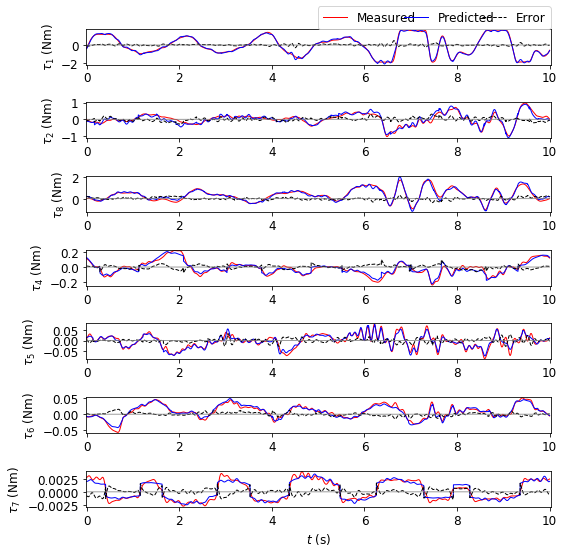

In [73]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num] - t_cut_train[0],
                   tau_f_train[:plot_data_num, :],
                   tau_p_sdp_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on test set

In [74]:
bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_test, tau_s_test = gen_regressor(bary_param_num, H_func,
                                   q_f_test, dq_f_test, ddq_f_test, tau_f_test)

In [80]:
tau_p_sdp_test = np.zeros(tau_f_test.shape)
tau_ps_sdp_test = W_test.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_test[:, i] = tau_ps_sdp_test[i::dof]
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_test[:plot_data_num, :],
                   tau_p_sdp_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

In [76]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_sdp_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.09879577, 0.32548518, 0.28563868, 0.25714807, 0.25187338,
       0.29823386, 0.24384046])

In [64]:
ympy.Matrix.hstack(sympy.Matrix(robot_model.bary_param), sympy.Matrix(sdp_opt_std.x_result))

⎡L1xx     2.6343054888674   ⎤
⎢                           ⎥
⎢L1xy  -4.46223463925424e-14⎥
⎢                           ⎥
⎢L1xz  9.56844769208569e-24 ⎥
⎢                           ⎥
⎢L1yy    2.63430548886742   ⎥
⎢                           ⎥
⎢L1yz  1.11467480731081e-17 ⎥
⎢                           ⎥
⎢L1zz   8.48601005291674e-6 ⎥
⎢                           ⎥
⎢l1x   5.85046325777972e-23 ⎥
⎢                           ⎥
⎢l1y   -1.89889430298544e-17⎥
⎢                           ⎥
⎢l1z     0.515973583715752  ⎥
⎢                           ⎥
⎢ m₁     3.82378587565491   ⎥
⎢                           ⎥
⎢Fc₁    0.0319006663095601  ⎥
⎢                           ⎥
⎢Fv₁    0.0552209852590067  ⎥
⎢                           ⎥
⎢Fo₁    -0.0608126942836563 ⎥
⎢                           ⎥
⎢L2xx   0.0185035212076023  ⎥
⎢                           ⎥
⎢L2xy   0.00633619756614463 ⎥
⎢                           ⎥
⎢L2xz   0.00250272253380045 ⎥
⎢                           ⎥
⎢L2yy    0.013261627741961  ⎥
⎢         

In [65]:
from identification import barycentric2standard_params

In [66]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_model)

In [67]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.std_param), sympy.Matrix(x_std))

⎡I1xx    2.56468110409537   ⎤
⎢                           ⎥
⎢I1xy  -4.46223463925424e-14⎥
⎢                           ⎥
⎢I1xz  1.74629391507553e-23 ⎥
⎢                           ⎥
⎢I1yy    2.56468110409538   ⎥
⎢                           ⎥
⎢I1yz  8.58442023763276e-18 ⎥
⎢                           ⎥
⎢I1zz   8.48601005291674e-6 ⎥
⎢                           ⎥
⎢r1x    1.5300185334718e-23 ⎥
⎢                           ⎥
⎢r1y   -4.96600585057657e-18⎥
⎢                           ⎥
⎢r1z     0.134937886297668  ⎥
⎢                           ⎥
⎢ m₁     3.82378587565491   ⎥
⎢                           ⎥
⎢Fc₁    0.0319006663095601  ⎥
⎢                           ⎥
⎢Fv₁    0.0552209852590067  ⎥
⎢                           ⎥
⎢Fo₁    -0.0608126942836563 ⎥
⎢                           ⎥
⎢I2xx   0.0176099112247765  ⎥
⎢                           ⎥
⎢I2xy   0.00433958872950056 ⎥
⎢                           ⎥
⎢I2xz   -2.8759159057212e-5 ⎥
⎢                           ⎥
⎢I2yy   0.00107829944199846 ⎥
⎢         